In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


## Helper functions

For visulalisation purposes

In [2]:
def imshow(img, text = None, should_save = False):
    npimg = img.numpy()
    plt.axis("off")
    if text is not None:
        plt.text(75, 8,text, style = 'italic', fontweight = 'bold',bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0))) #permute the axis and show them
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()
        

## Configuration Function

Change here for a global effect

In [3]:
class Config():
    training_dir = './data/train'
    testing_dir = './data/test'
    train_batch_size = 8 #change this according to requirement
    train_number_epochs = 100 #change this according to requirement

## Dataset Class

Returns two images and a label.

Label 0 - if both images belong to similar class
Label 1 - if they belong to different class

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]: #stop looping once you have found image of same class
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]: #stop looping once you have found image of dissimilar class
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L") #convert to monochrome
        img1 = img1.convert("L") #convert to monochrome
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        
        #dissimilar will have 1 and similar will have 0. We are interested in dissimilarity therefore 1 is assigned to dissimilar
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
folder_dataset = dset.ImageFolder(root = Config.training_dir)

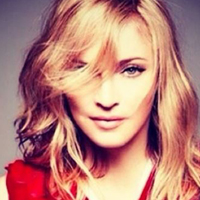

In [6]:
folder_dataset[39][0]
#output of ImageFolder function of dset gives a tuple
#The the first [] indicates what image is chosen
#the second [] [0] shows the image itself , [][1] shows the integer label of the class assigned by pytorch
#the current dataset has training folder with 41 images of 4 classes.

In [7]:
#translating the dataset to make it ready for siamese dataset
siamese_dataset = SiameseNetworkDataset(imageFolderDataset = folder_dataset, 
                                       transform = transforms.Compose([
                                           transforms.Resize((100,100)),
                                           transforms.ToTensor()
                                       ])
                                       ,should_invert = False)

## Visualising the data



Length of number of images and corresponding labels in a batch: 8
Dimension of image: torch.Size([1, 100, 100])
torch.Size([16, 1, 100, 100])


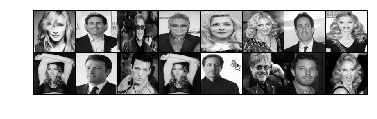

tensor([[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]])


In [8]:
vis_dataloader = DataLoader(siamese_dataset,
                           shuffle = True,
                           num_workers = 8,
                           batch_size = 8) #load the dataset

dataiter = iter(vis_dataloader)

first_batch = next(dataiter)

print("Length of number of images and corresponding labels in a batch: {}".format(len(first_batch[0])))
print("Dimension of image: {}".format(first_batch[0][1].size())) #1 channel (monochrome) and size = 100 * 100
concatenated = torch.cat((first_batch[0], first_batch[1]), 0) #concatenate both batches = total sixteen images (including img1 and img2)
print(concatenated.size())
imshow(torchvision.utils.make_grid(concatenated))

print(first_batch[2])


In [9]:
#TESTING DATASET
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

In [10]:
print(x0)

tensor([[[[0.7765, 0.7765, 0.7765,  ..., 0.7922, 0.7882, 0.7843],
          [0.7843, 0.7843, 0.7843,  ..., 0.7922, 0.7922, 0.7922],
          [0.7882, 0.7882, 0.7843,  ..., 0.7882, 0.7882, 0.7882],
          ...,
          [0.6157, 0.5922, 0.5686,  ..., 0.3451, 0.3412, 0.3412],
          [0.6275, 0.5961, 0.5725,  ..., 0.3451, 0.3451, 0.3373],
          [0.6235, 0.6000, 0.5725,  ..., 0.3294, 0.3412, 0.3373]]]])


The label 0 indicates IMAGES FROM SAME CLASS and 1 indicates IMAGES FROM DIFFERENT CLASS


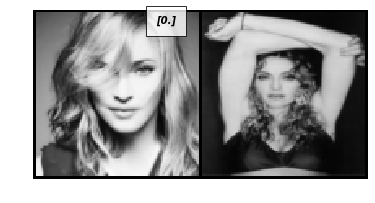

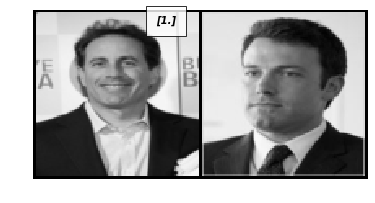

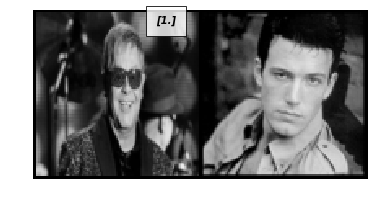

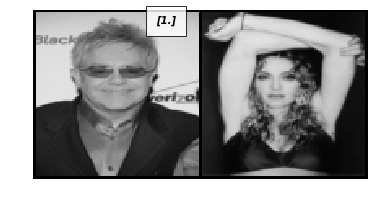

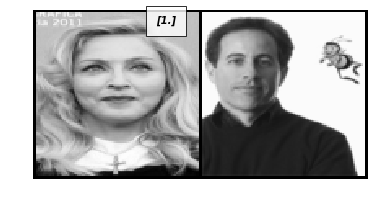

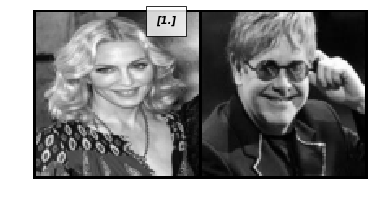

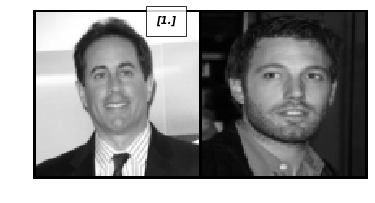

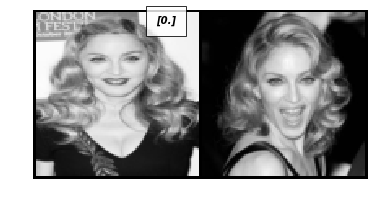

In [11]:
# second way of visualising

print("The label 0 indicates IMAGES FROM SAME CLASS and 1 indicates IMAGES FROM DIFFERENT CLASS")
for i in range(len(first_batch[0])):
    #print image tuples of first batch
    cat = torch.cat((first_batch[0][i], first_batch[1][i]), 0)
    imshow(torchvision.utils.make_grid(cat.view(2,1,100,100)), text = str(first_batch[2][i].numpy()))

# Neural Net Definition

In [12]:
class SiameseNeuralNetwork(nn.Module):
    def __init__(self):
        super(SiameseNeuralNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(1, 4, kernel_size = 3),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(4)
        )
        
        self.cnn2 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(4, 8, kernel_size=3),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(8)
        )
        
        self.cnn3 = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(8, 8, kernel_size=3),
        nn.ReLU(inplace = True),
        nn.BatchNorm2d(8)
        )
        
        self.fc1 = nn.Sequential(
        nn.Linear(8 * 100 * 100, 500),
        nn.ReLU(inplace = True),
        nn.Linear(500,500),
        nn.ReLU(inplace = True),
        nn.Linear(500,5)
        )
        
    
    def forward_once(self, x):
        output = self.cnn1(x)
        output = self.cnn2(output)
        output = self.cnn3(output)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss


In [13]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin #margin to set threshold to what learning to consider and what not to.

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Training Phase

In [14]:
train_dataloader = DataLoader(siamese_dataset,
                             shuffle=True,
                             num_workers=4,
                             batch_size = Config.train_batch_size)

In [15]:
net = SiameseNeuralNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

In [16]:
counter = []
loss_list = []
iteration_number = 0

Epoch Number: 0 Current Loss: 1.804565668106079
Epoch Number: 1 Current Loss: 16.710241317749023
Epoch Number: 2 Current Loss: 4.077218532562256
Epoch Number: 3 Current Loss: 16.721826553344727
Epoch Number: 4 Current Loss: 4.769171714782715
Epoch Number: 5 Current Loss: 5.300808906555176
Epoch Number: 6 Current Loss: 1.2805646657943726
Epoch Number: 7 Current Loss: 1.713005781173706
Epoch Number: 8 Current Loss: 1.98972749710083
Epoch Number: 9 Current Loss: 3.8713438510894775
Epoch Number: 10 Current Loss: 1.262433648109436
Epoch Number: 11 Current Loss: 2.951707363128662
Epoch Number: 12 Current Loss: 4.548838138580322
Epoch Number: 13 Current Loss: 1.6324036121368408
Epoch Number: 14 Current Loss: 0.9523786902427673
Epoch Number: 15 Current Loss: 1.1335456371307373
Epoch Number: 16 Current Loss: 1.8551751375198364
Epoch Number: 17 Current Loss: 0.7731953859329224
Epoch Number: 18 Current Loss: 1.2395657300949097
Epoch Number: 19 Current Loss: 1.2980929613113403
Epoch Number: 20 Cur

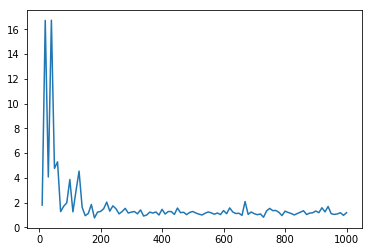

In [17]:
for epoch in range(Config.train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0:
            print("Epoch Number: {} Current Loss: {}".format(epoch,loss_contrastive.item()))
            iteration_number += 10
            counter.append(iteration_number)
            loss_list.append(loss_contrastive.item())
            
show_plot(counter, loss_list)

# Validation

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x11ce41898>>
Traceback (most recent call last):
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 167, in rebuild_storage_filename
    storage = cls._new_shared_filename(manager, handle, size)
RuntimeError: Interrupted system call at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/libshm/core.cpp:99


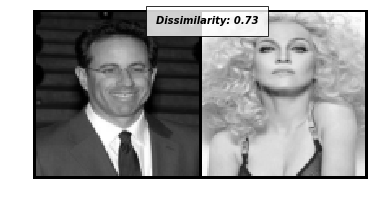

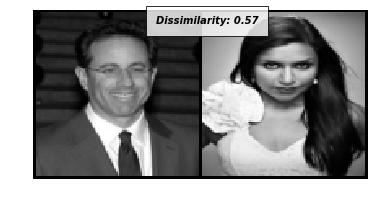

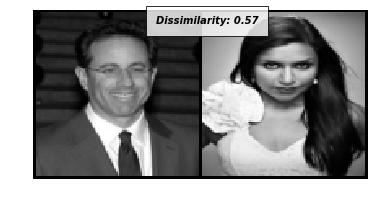

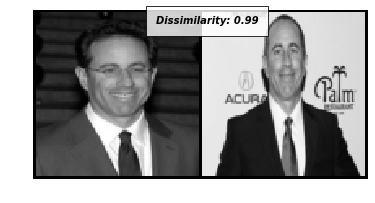

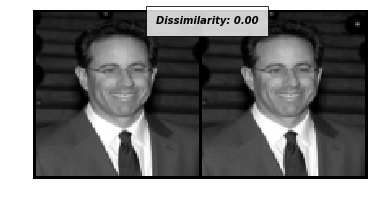

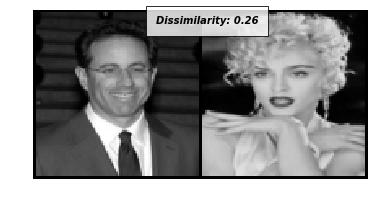

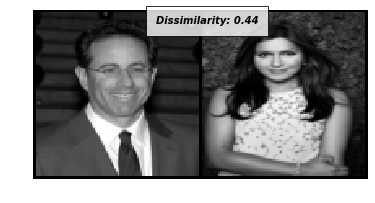

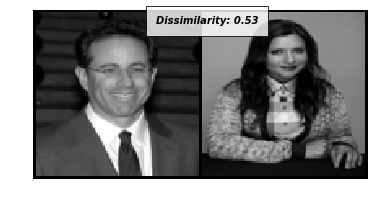

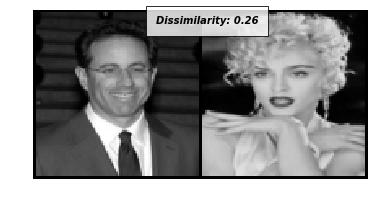

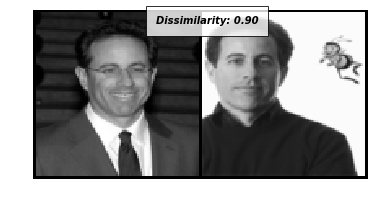

In [21]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=4,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)


for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))


